In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchAA import torchAA
from torchNMF import NMF
from ShiftNMF_half_frequencies import ShiftNMF
from torchShiftAA import torchShiftAA
from tqdm.notebook import tqdm
import torch

from scipy.special import softmax

cpu


## Data

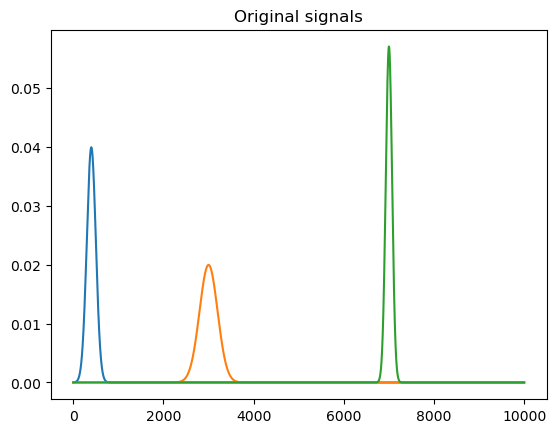

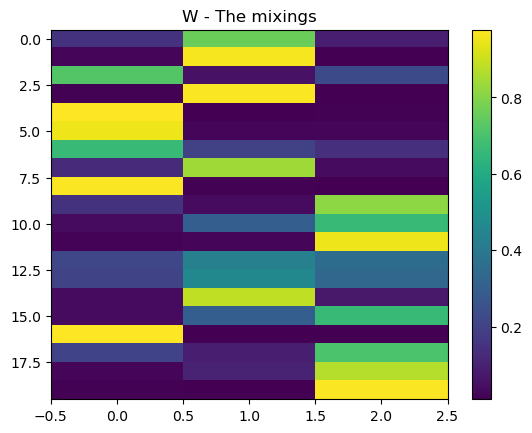

In [11]:
#Create data
# Define random sources, mixings and shifts; H, W and tau
N, M, d = 20, 10000, 3
Fs = 1000  # The sampling frequency we use for the simulation
t0 = 10    # The half-time interval we look at
t = np.arange(-t0, t0, 1/Fs)  # the time samples
f = np.arange(-Fs/2, Fs/2, Fs/len(t))  # the corresponding frequency samples

def gauss(mu, s, time):
    return 1/(s*np.sqrt(2*np.pi))*np.exp(-1/2*((time-mu)/s)**2)


def shift_dataset(W, H, tau):
    # Get half the frequencies
    Nf = H.shape[1] // 2 + 1
    # Fourier transform of S along the second dimension
    Hf = np.fft.fft(H, axis=1)
    # Keep only the first Nf[1] elements of the Fourier transform of S
    Hf = Hf[:, :Nf]
    # Construct the shifted Fourier transform of S
    Hf_reverse = np.fliplr(Hf[:, 1:Nf - 1])
    # Concatenate the original columns with the reversed columns along the second dimension
    Hft = np.concatenate((Hf, np.conj(Hf_reverse)), axis=1)
    f = np.arange(0, M) / M
    omega = np.exp(-1j * 2 * np.pi * np.einsum('Nd,M->NdM', tau, f))
    Wf = np.einsum('Nd,NdM->NdM', W, omega)
    # Broadcast Wf and H together
    Vf = np.einsum('NdM,dM->NM', Wf, Hft)
    V = np.fft.ifft(Vf)
    return V

# Random mixings:
W = np.random.dirichlet(np.ones(d)*0.5, N)*5
W = softmax(W, axis=1)

#W = np.random.rand(N, d)
# Random gaussian shifts
tau = np.zeros(shape=(N, d))
#tau = np.random.randint(0, 1000, size=(N, d))
# Purely positive underlying signals. I define them as 3 gaussian peaks with random mean and std.
mean = [40, 300, 700]
std = [10, 20, 7]
t = np.arange(0, 1000, 0.1)
H = np.array([gauss(m, s, t) for m, s in list(zip(mean, std))])
plt.figure()
for signal in H:
    plt.plot(signal)
plt.title("Original signals")
plt.show()

X = shift_dataset(W, H, tau)


# plt.figure()
# for signal in X:
#     plt.plot(signal.real)
# plt.title("Dataset build from mixing of the three sources")
# plt.show()

plt.figure()
plt.imshow(W, aspect='auto', interpolation="none")
plt.colorbar()
ax = plt.gca()
ax.set_xticks(np.arange(0, d, 1))
ax.set_yticks(np.arange(0, N, 1))
plt.title("W - The mixings")
plt.show()

## Regular NMF

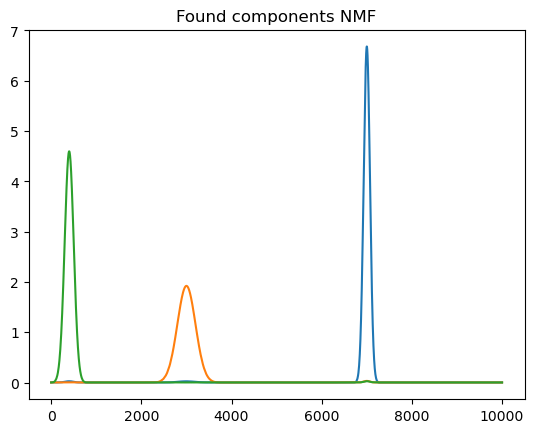

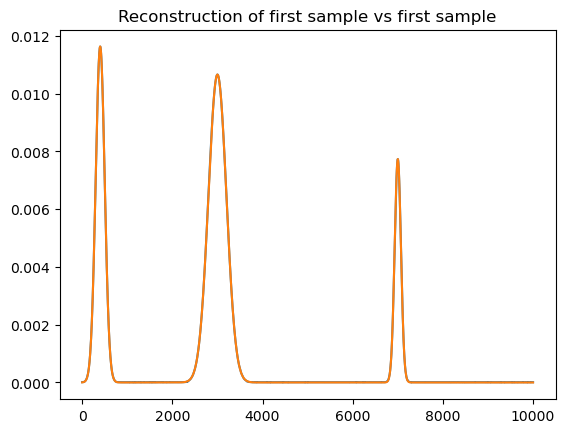

In [4]:

nmf = NMF(X, 3)
W, H = nmf.fit(verbose=True)
recon = np.matmul(W, H)

for signal in H:
    plt.plot(signal)
plt.title("Found components NMF")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample")
plt.show()

## Shift NMF

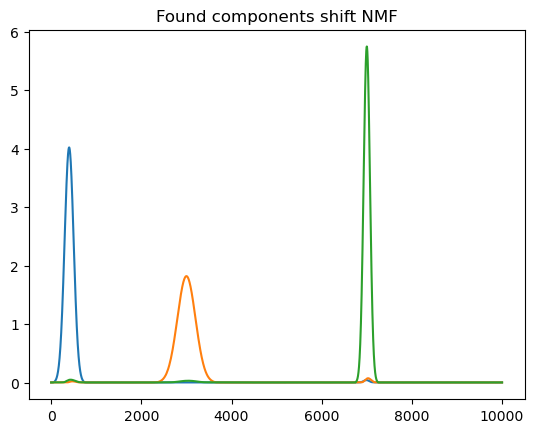

c:\Users\Lenovo\miniconda3\envs\fp\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


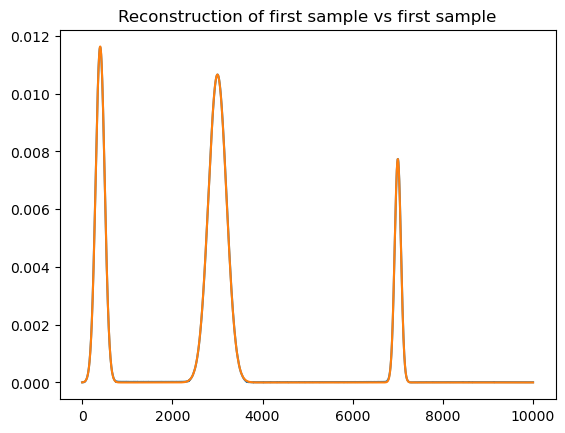

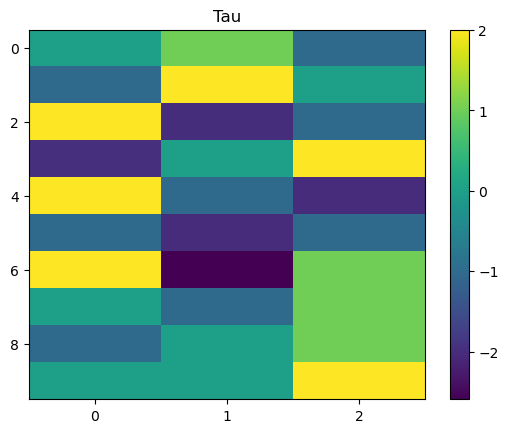

In [3]:

nmf = ShiftNMF(X, 3)
W, H, tau = nmf.fit(verbose=True)
recon = nmf.recon.detach().numpy()

for signal in H:
    plt.plot(signal)
plt.title("Found components shift NMF")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample")
plt.show()

plt.figure()
plt.imshow(tau, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau")
plt.show()
print(tau)

## Regular AA

  0%|          | 0/1 [00:00<?, ?it/s]

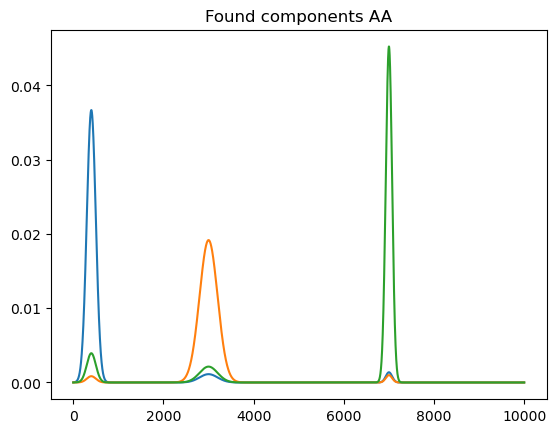

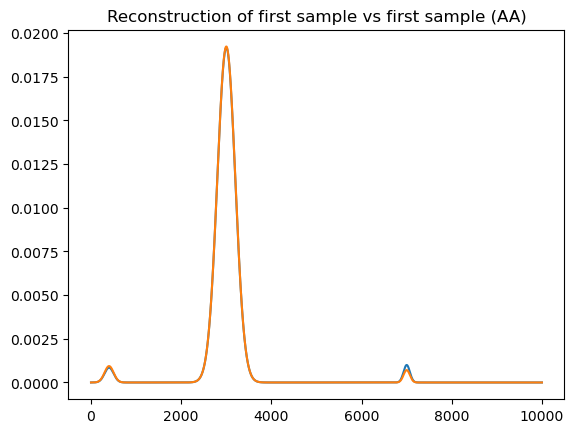

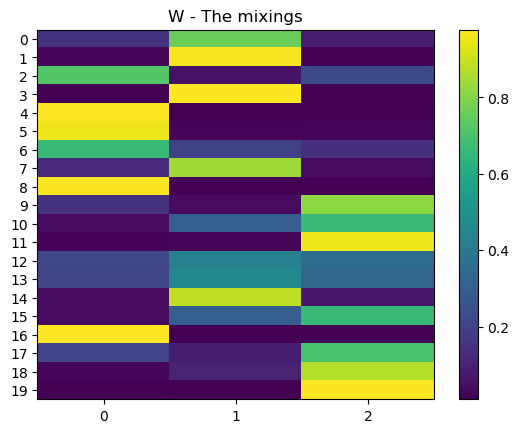

In [14]:
best_loss = np.inf
for _ in tqdm(range(1)):
    AA = torchAA(X, 3)
    C, S, loss = AA.fit(verbose=True, return_loss=True)
    if loss[-1] < best_loss:
        CX = np.matmul(C, X)
        recon = np.matmul(S, CX)
        best_loss = loss[-1]

for signal in CX:
    plt.plot(signal)
plt.title("Found components AA")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample (AA)")
plt.show()

plt.figure()
plt.imshow(W, aspect='auto', interpolation="none")
plt.colorbar()
ax = plt.gca()
ax.set_xticks(np.arange(0, d, 1))
ax.set_yticks(np.arange(0, N, 1))
plt.title("W - The mixings")
plt.show()

## Shift AA

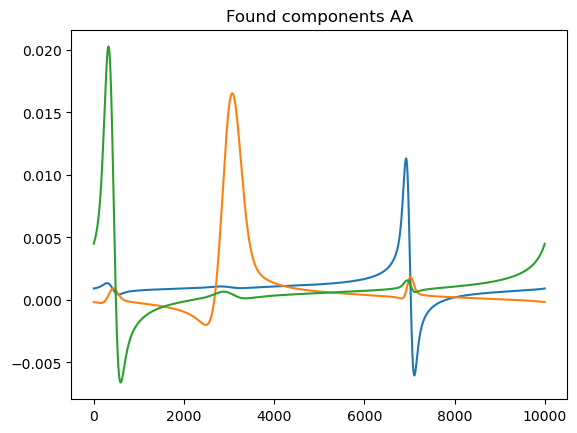

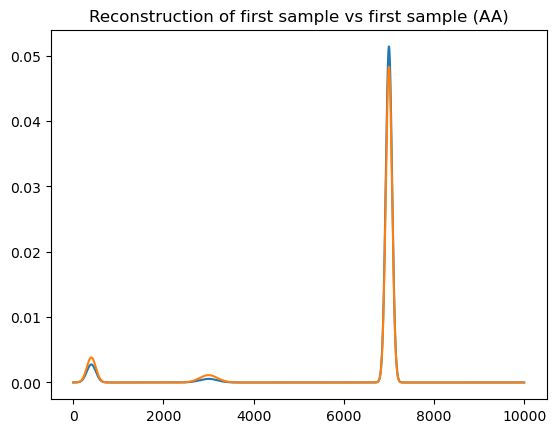

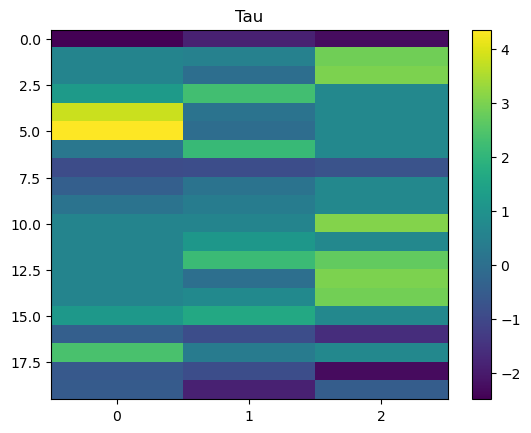

In [7]:
AA = torchShiftAA(X, 3)
C, S, tau = AA.fit(verbose=True)

recon = AA.recon.detach().resolve_conj().numpy()
A = torch.fft.ifft(AA.A_F).detach().numpy()

CX = A
SCX = recon

for signal in CX:
    plt.plot(signal)
plt.title("Found components AA")
plt.show()

plt.plot(recon[1])
plt.plot(X[1])
plt.title("Reconstruction of first sample vs first sample (AA)")
plt.show()

plt.figure()
plt.imshow(tau, aspect='auto', interpolation="none")
ax = plt.gca()
ax.set_xticks(np.arange(0, 3, 1))
plt.colorbar()
plt.title("Tau")
plt.show()

In [8]:
print(tau)

[[-2.4895215  -1.8567593  -2.2566648 ]
 [ 0.58981496  0.51614267  2.876199  ]
 [ 0.58973795 -0.0119862   3.0008147 ]
 [ 1.2393657   2.2865531   0.71270406]
 [ 3.811714    0.12282678  0.7128729 ]
 [ 4.360607   -0.04599219  0.7122502 ]
 [ 0.23692122  2.1195388   0.71268034]
 [-0.9008731  -0.8599371  -0.7277271 ]
 [-0.42409843  0.13252665  0.713155  ]
 [ 0.12908886  0.3955968   0.71286774]
 [ 0.59014815  0.61063856  3.0983114 ]
 [ 0.5894394   1.1382335   0.71296805]
 [ 0.5894205   2.1707919   2.7265208 ]
 [ 0.58993745  0.0179582   3.0113323 ]
 [ 0.5894877   0.7492529   2.9057527 ]
 [ 1.151203    1.6540297   0.71261954]
 [-0.41183767 -0.8591832  -1.6004874 ]
 [ 2.397841    0.3510031   0.7127915 ]
 [-0.5813996  -0.8603095  -2.288658  ]
 [-0.52366066 -1.8613212  -0.4736373 ]]
